In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, f1_score
%matplotlib inline

In [2]:
data = pd.read_csv('daily_weather.csv')

The following information was provided with the dataset:

This data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014.

Since this dataset was created to classify low-humidity days vs. non-low-humidity days (days with normal or high humidity), the variables included are weather measurements taken in the morning and one measurement, relatively humidity,  taken in the afternoon.

Each row, or sample, consists of the following variables:
* **number:** unique identifier
* **air_pressure_9am:** air pressure at 9am (*Unit: hectopascals*)
* **air_temp_9am:** air temperature at 9am (*Unit: degrees Fahrenheit*)
* **air_wind_direction_9am:** wind direction at 9am (*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **air_wind_speed_9am:** wind speed at 9am (*Unit: miles per hour*)
* **max_wind_direction_9am:** wind gust direction at 9am (*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed_9am:** wind gust speed at 9am (*Unit: miles per hour*)
* **rain_accumulation_9am:** amount of rain accumulated in the 24 hours prior to 9am (*Unit: millimeters*)
* **rain_duration_9am:** amount of time rain was recorded in the 24 hours prior to 9am (*Unit: seconds*)
* **relative_humidity_9am:** relative humidity at 9am (*Unit: percent*)
* **relative_humidity_3pm:** relative humidity at 3pm (*Unit: percent*)

In [3]:
data.columns

Index(['number', 'air_pressure_9am', 'air_temp_9am', 'avg_wind_direction_9am',
       'avg_wind_speed_9am', 'max_wind_direction_9am', 'max_wind_speed_9am',
       'rain_accumulation_9am', 'rain_duration_9am', 'relative_humidity_9am',
       'relative_humidity_3pm'],
      dtype='object')

In [4]:
del data['number']
data = data.dropna()
data.head()

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
0,918.060000,74.822000,271.100000,2.080354,295.400000,2.863283,0.0,0.0,42.420000,36.160000
1,917.347688,71.403843,101.935179,2.443009,140.471548,3.533324,0.0,0.0,24.328697,19.426597
2,923.040000,60.638000,51.000000,17.067852,63.700000,22.100967,0.0,20.0,8.900000,14.460000
3,920.502751,70.138895,198.832133,4.337363,211.203341,5.190045,0.0,0.0,12.189102,12.742547
4,921.160000,44.294000,277.800000,1.856660,136.500000,2.863283,8.9,14730.0,92.410000,76.740000


My goal in this mini project is to effectively predict relative humidity at 3pm using the features provided to me in the dataset. 

Before that, I wanted to understand a little more about what I'm trying to predict. With a little research, I learned that there is no threshold for 'high' relative humidity levels and that relative humidity is a poor metric to use when quantifying 'muginess'. Why? Simply put, **relative** humidity is **relative** to the temperature. The amount of moisture in air changes as the temperature changes. In other words, "air that’s 85 degrees with 25 percent humidity contains twice as much moisture as 35-degree air with 75 percent humidity" (Angela Fritz - Washington Post 2017). 

As temperature increases, the air particles (nitrogen, oxygen, etc) gain kinetic energy. When this occurs, the equilibrium between water in its liquid form and atmospheric water vapor is disturbed, resulting in a higher partial pressure of water vapor. To achieve equilibrium, more water molecules enter the vapor phase. In short, we shouldn't use relative humidity to quantify 'muginess'. Unfortunately, since we have a partial dataset and my aim is to practice classification techniques I'll use relative humidity for now. 

Here is a short function which converts the temperature and relative humidity into dew point. Dew point is the temperature at which water vapor in the air will begin condensing to form droplets. Dew point is a real indicator of **total** moisture levels in the air, regardless of the temperature. To improve this mini project, dew point is the indicator of 'muginess' which should be employed.

In [5]:
def calc_dewpoint(temp, rh):
    a=17.62
    b=243.12
    #celsius = (temp - 32) * 5.0/9.0 - not necessary to convert to Celsius
    alpha = math.log(rh/100) + ((a*temp)/(b+temp))
    dew_point = (b*alpha)/(a-alpha)
    return dew_point   

In [6]:
calc_dewpoint(74.822, 42.42)

55.79671864537919

In [7]:
## Create labels for high and low humidity levels (0 for low and 1 for high)
data['high_humidity'] = (data['relative_humidity_3pm']>54.99)*1

In [12]:
Y = data['high_humidity']
humidity_label_counts = data['high_humidity'].value_counts()

print('Our dataset includes ' + str(humidity_label_counts[0]) + ' instances of low humidity at 3pm and '
      + str(humidity_label_counts[1]) + ' instances of high humidity at 3pm.')

Our dataset includes 842 instances of low humidity at 3pm and 222 instances of high humidity at 3pm.


Here is the list of features we will be using for our modeling exercises. I'm leaving off relative humidity at 9am from my feature list. Relative humidity does not change drastically in the six hour period between readings. In other words, it closely related to our label and would greatly influence how our models learn. 

In [13]:
morning_features = ['air_pressure_9am', 'air_temp_9am', 'avg_wind_direction_9am',
                    'avg_wind_speed_9am', 'max_wind_direction_9am', 'max_wind_speed_9am',
                    'rain_accumulation_9am', 'rain_duration_9am']

In [14]:
X = data[morning_features]

In [15]:
X_train, X_test, y_train, y_test=train_test_split(X, Y)

**Complete the following tasks**:

- Train a logistic regression model (10 points)
- Train a SVM model by tunning both C and gamma, report the best parameters (15 points)
- Train a decision tree model by tuning the proper parameters, report the best parameters (15 points)
- Use the same parameters to train a random forest model (10 points)
- Compare all the above models' performance (10 points)


## Logistic Regression

Logistic Regression Metrics: 
Precision score: 0.8250
Recall score: 0.5789
Accuracy score: 0.8835
F1 score: 0.6804
AUC Index: 0.8962

Confusion Matrix: 
[[202   7]
 [ 24  33]]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


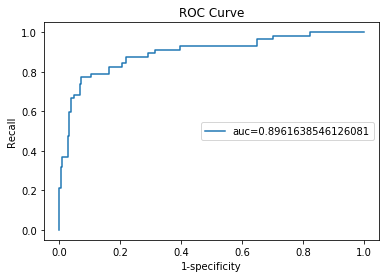

In [34]:
log_regression = LogisticRegression().fit(X_train, y_train)
logistic_y_pred = log_regression.predict(X_test)
print("Logistic Regression Metrics: ")
log_probs = log_regression.predict_proba(X_test)
log_AUC = roc_auc_score(y_test, log_probs[:, 1])
print('Precision score: {:.4f}'.format(precision_score(y_test,logistic_y_pred)))
print('Recall score: {:.4f}'.format(recall_score(y_test,logistic_y_pred)))
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test,logistic_y_pred)))
print('F1 score: {:.4f}'.format(f1_score(y_test,logistic_y_pred)))
print('AUC Index: {:.4f}\n'.format(log_AUC))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, logistic_y_pred))

## ROC/AUC curve
fpr, tpr, threshold = roc_curve(y_test,  log_probs[:, 1])
plt.plot(fpr,tpr,label="auc="+str(log_AUC))
plt.legend(loc=5)
plt.ylabel('Recall')
plt.xlabel('1-specificity')
plt.title('ROC Curve')
plt.show()

## SVM

Best parameters:  {'C': 100, 'gamma': 0.0001}
Precision score: 0.7451
Recall score: 0.6667
Accuracy score: 0.8797
F1 score: 0.7037
AUC Index: 0.8996

Confusion Matrix: 
[[196  13]
 [ 19  38]]


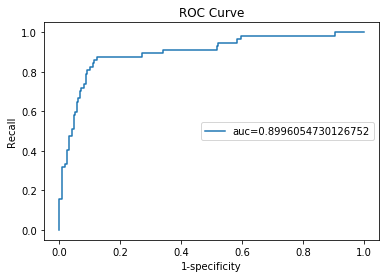

In [46]:
svm_kernel = SVC(kernel = 'rbf', probability=True)
#define a list of parameters
param_svm_kernel = {'C': [.0001,.001,.01,.1,1,10,100,1000,10000], 'gamma':[.0001,.001,.01,.1,1,10,100,1000,10000]}
#apply grid search - tuning SVM
grid_svm_kernel = GridSearchCV(svm_kernel, param_svm_kernel, cv=5, n_jobs=-1, scoring='roc_auc')
grid_svm_kernel.fit(X_train, y_train)
print('Best parameters: ',grid_svm_kernel.best_params_)

## rbf SVM Metrics
grid_rbf_svm_y_pred = grid_svm_kernel.predict(X_test)
grid_rbf_svm_probs = grid_svm_kernel.predict_proba(X_test)
grid_rbf_svm_AUC = roc_auc_score(y_test, grid_rbf_svm_probs[:, 1])

print('Precision score: {:.4f}'.format(precision_score(y_test,grid_rbf_svm_y_pred)))
print('Recall score: {:.4f}'.format(recall_score(y_test,grid_rbf_svm_y_pred)))
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test,grid_rbf_svm_y_pred)))
print('F1 score: {:.4f}'.format(f1_score(y_test,grid_rbf_svm_y_pred)))
print('AUC Index: {:.4f}\n'.format(grid_rbf_svm_AUC))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, grid_rbf_svm_y_pred))

## ROC/AUC curve
fpr, tpr, threshold = roc_curve(y_test,  grid_rbf_svm_probs[:, 1])
plt.plot(fpr,tpr,label="auc="+str(grid_rbf_svm_AUC))
plt.legend(loc=5)
plt.ylabel('Recall')
plt.xlabel('1-specificity')
plt.title('ROC Curve')
plt.show()

## Decision Tree

Best parameters:  {'max_depth': 5, 'max_leaf_nodes': 9, 'min_samples_split': 2}
Precision score: 0.8409
Recall score: 0.6491
Accuracy score: 0.8985
F1 score: 0.7327
AUC Index: 0.8290

Confusion Matrix: 
[[202   7]
 [ 20  37]]


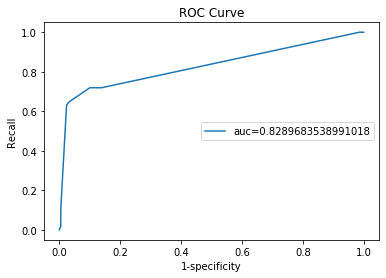

In [44]:
opt_tree = DecisionTreeClassifier()
params = {"max_depth": range(1,15),
           "min_samples_split": range(2,20,1),
           "max_leaf_nodes": range(2,10)}
grid_tree = GridSearchCV(opt_tree,params,cv=5)
grid_tree.fit(X_train,y_train)
print('Best parameters: ', grid_tree.best_params_)

grid_tree_y_pred = grid_tree.predict(X_test)
grid_tree_probs = grid_tree.predict_proba(X_test)
grid_tree_AUC = roc_auc_score(y_test, grid_tree_probs[:, 1])  

print('Precision score: {:.4f}'.format(precision_score(y_test, grid_tree_y_pred)))
print('Recall score: {:.4f}'.format(recall_score(y_test, grid_tree_y_pred)))
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, grid_tree_y_pred)))
print('F1 score: {:.4f}'.format(f1_score(y_test, grid_tree_y_pred)))
print('AUC Index: {:.4f}\n'.format(grid_tree_AUC))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, grid_tree_y_pred))

## ROC/AUC curve
fpr, tpr, threshold = roc_curve(y_test,  grid_tree_probs[:, 1])
plt.plot(fpr,tpr,label="auc="+str(grid_tree_AUC))
plt.legend(loc=5)
plt.ylabel('Recall')
plt.xlabel('1-specificity')
plt.title('ROC Curve')
plt.show()

Precision score: 0.8261
Recall score: 0.6667
Accuracy score: 0.8985
F1 score: 0.7379
AUC Index: 0.9217

Confusion Matrix: 
[[201   8]
 [ 19  38]]


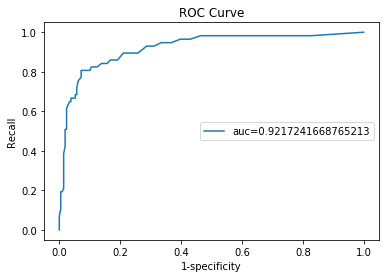

In [45]:
## Random Forest
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train, y_train)
## Random Forest Metrics
rf_y_pred = random_forest_clf.predict(X_test)
rf_probs = random_forest_clf.predict_proba(X_test)
rf_AUC = roc_auc_score(y_test, rf_probs[:, 1])

print('Precision score: {:.4f}'.format(precision_score(y_test, rf_y_pred)))
print('Recall score: {:.4f}'.format(recall_score(y_test, rf_y_pred)))
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, rf_y_pred)))
print('F1 score: {:.4f}'.format(f1_score(y_test, rf_y_pred)))
print('AUC Index: {:.4f}\n'.format(rf_AUC))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, rf_y_pred))

## ROC/AUC curve
fpr, tpr, threshold = roc_curve(y_test,  rf_probs[:, 1])
plt.plot(fpr,tpr,label="auc="+str(rf_AUC))
plt.legend(loc=5)
plt.ylabel('Recall')
plt.xlabel('1-specificity')
plt.title('ROC Curve')
plt.show()